In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random
%matplotlib inline


In [2]:
Mnist_df = pd.read_csv("ex3_train.csv")
# Alternative way of doing -----Mnist_df_train_data = Mnist_df.as_matrix(columns=Mnist_df.columns[0:400])
Mnist_df_train_data = Mnist_df.values
Mnist_df_train_label = Mnist_df.as_matrix(columns=Mnist_df.columns[400:401])
Mnist_df_train_data_with_bias = np.c_[np.ones((Mnist_df_train_data.shape[0] ,1)),Mnist_df_train_data]## Add 1 for the bias

In [3]:
Mnist_df_test = pd.read_csv("ex3_test.csv")
Mnist_df_test_data = Mnist_df_test.values
Mnist_df_test_label = Mnist_df_test.as_matrix(columns=Mnist_df.columns[400:401])
Mnist_df_test_data_with_bias = np.c_[np.ones((Mnist_df_test_data.shape[0] ,1)),Mnist_df_test_data]## Add 1 for the bias

7.0


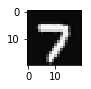

In [4]:
fig = plt.figure(figsize=(1,1))
plt.imshow(np.reshape(Mnist_df_train_data[:,:-1][2],[20,20]).T,cmap='gray')
print (Mnist_df_train_data[2][-1])

In [5]:
## Label set - containing unique labels
Mnist_df_train_label_uq = set(Mnist_df.values[:,400].astype(int))

In [6]:
## Not Being used for this assignment
def hot_encoding_dict(label_set):
    identity_matrix = np.identity(len(label_set)).astype(int)
    hot_encoding_dict = {v:identity_matrix[:,i] for i,v in enumerate(label_set)}
    return hot_encoding_dict

In [7]:
## Being used for this assignment
def label_dict_gen(label_set): ## Useful for scaling if  huge number of labels (both number and string)
    label_dict = {}
    count = 0
    for label in label_set:
        label_dict[label]=count
        count +=1
    return label_dict
        

In [8]:
## Not Being used for this assignment - better method exists for calculating the cross entropy loss
## Nielsen Deep Learning applicable for number labels ,if input is string label enumerate the labels and then use the  
## enumerated index below 
def hot_encoding_lower_memory_footprint(label,number_of_labels):
    e = np.zeros((number_of_labels, 1))
    e[label] = 1.0
    return e

In [9]:
## Not Being used for this assignment - better method exists for calculating the cross entropy loss
## Refer - corect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])## Andrej Karpathy Course
def prepare_true_label_hot_encoding_array(label_dict,labels):
    label_list = []
    for label in labels:
        label_list.append(hot_encoding_lower_memory_footprint(label_dict[label],len(label_dict)))
    label_list = np.array(label_list)
    return label_list.reshape(-1,len(label_dict)).T
    

In [10]:
## print (prepare_true_label_hot_encoding_array(label_dict(Mnist_df_train_label_uq),[0,0,1,9,2,3]))

In [11]:
def sigmoid(data):
    return 1/(1+np.exp(-data))

In [12]:
def softmax_prediction(data):
    result= np.exp(data) / np.sum(np.exp(data), axis=1, keepdims=True)
    return result ## The max proability per coloumn(each coloumn represents a record , and 
                                         ## The complete result matrix to calculate the loss

In [13]:
## Initialize weights along with weights for bias set to zero
def weights_list_generator(features,hidden_layers_list,no_output_class):
    np.random.seed(1)
    weights_array=[]
    for i in range(len(hidden_layers_list)):
        if i == 0 :
            weights_array=[.01*np.random.randn(features,hidden_layers_list[0])]
           ## Add row of zeroes for bias term's initial weights (initialized to zero)
            weights_array[0] = np.r_[np.zeros(( 1,hidden_layers_list[0])),weights_array[0]]
        else :
            weights_array.append(.01*np.random.randn(hidden_layers_list[i-1],hidden_layers_list[i]))
            ## Add row of zeroes for bias term's initial weights (initialized to zero)
            weights_array[i] = np.r_[np.zeros(( 1,hidden_layers_list[i])),weights_array[i]]
    weights_array.append(.01*np.random.randn(hidden_layers_list[-1],no_output_class))
    weights_array[-1] = np.r_[np.zeros(( 1,no_output_class)),weights_array[-1]]
    return weights_array


In [14]:
#weights_list_try = weights_list_generator(400,[25],10)

In [15]:
#weights_list_try[1][1:,:].shape

In [16]:
#weights_list_try[1]

In [17]:
'''
weights_list = weights_list_generator(400,[25],10)
hidden_input = np.dot(Mnist_df_train_data_with_bias[:,:-1],weights_list[0])
hidden_output = sigmoid(hidden_input)
hidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]
#print ((1-hidden_output))
#print ((1-hidden_output[:,1:]))
#print (hidden_output[:,1:].shape)
output_before_softmax = np.dot(hidden_output,weights_list[1])
#print(output_before_softmax)
#print(output_before_softmax.shape)
softmax_output = softmax_prediction(output_before_softmax)
#print(softmax_output)
#print(softmax_output.shape)
label_dict = label_dict_gen(Mnist_df_train_label_uq)
label_general = [label_dict[label] for label in Mnist_df_train_data_with_bias[:,-1]]
label_general = np.asarray(label_general)
corect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])
#print (corect_logprobs)
#print (corect_logprobs.shape)
## Sum the individual terms of output of autoencoding snd softmax in the above step and average it
loss = np.sum(corect_logprobs)/softmax_output.shape[0]    

# compute the gradient on scores
dsoftmax = softmax_output
dsoftmax[range(softmax_output.shape[0]),label_general] -= 1 ## Very elegant only the element with true label is updated
#print (dsoftmax)
#print (dsoftmax.shape)
# backpropate the gradient to the 2nd layer weight
dW1 = np.dot(hidden_output.T, dsoftmax)/softmax_output.shape[0]
# perform a parameter update
#print (dW1)
#print (dW1.shape)
#print (weights_list[1])
gradient_descent(weights_list[1],dW1,.01)
#print (weights_list[1])
#print (weights_list[1].shape)
# Backpropagate the gradient to 1st layer 
print (weights_list[1][1:,:].shape)
yo = np.dot(dsoftmax,weights_list[1][1:,:].T)
#print(yo)
#print(yo.shape)
po = np.dot(Mnist_df_train_data_with_bias[:,:-1].T,np.dot(hidden_output[:,1:],(1-hidden_output)[:,1:].T))
#print (po)
#print (po.shape)
dW0 = np.dot(po,yo)/softmax_output.shape[0]
#print (dW0)
#print (dW0.shape)
# perform a parameter update
gradient_descent(weights_list[0],dW0,.01)
print(weights_list[0])
'''

'\nweights_list = weights_list_generator(400,[25],10)\nhidden_input = np.dot(Mnist_df_train_data_with_bias[:,:-1],weights_list[0])\nhidden_output = sigmoid(hidden_input)\nhidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]\n#print ((1-hidden_output))\n#print ((1-hidden_output[:,1:]))\n#print (hidden_output[:,1:].shape)\noutput_before_softmax = np.dot(hidden_output,weights_list[1])\n#print(output_before_softmax)\n#print(output_before_softmax.shape)\nsoftmax_output = softmax_prediction(output_before_softmax)\n#print(softmax_output)\n#print(softmax_output.shape)\nlabel_dict = label_dict_gen(Mnist_df_train_label_uq)\nlabel_general = [label_dict[label] for label in Mnist_df_train_data_with_bias[:,-1]]\nlabel_general = np.asarray(label_general)\ncorect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])\n#print (corect_logprobs)\n#print (corect_logprobs.shape)\n## Sum the individual terms of output of autoencoding snd softmax in the above st

In [18]:
def forward_prop(data,weights_list):
    hidden_input = np.dot(data[:,:-1],weights_list[0])
    hidden_output = sigmoid(hidden_input)
    hidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]## Add 1 for the bias 
    output_before_softmax = np.dot(hidden_output,weights_list[1])
    softmax_output = softmax_prediction(output_before_softmax)
    return softmax_output

In [19]:
def cross_entropy_loss(softmax_output,labels):
    ## General implementation to take care of any labels
    label_general = [label_dict(Mnist_df_train_label_uq)[label] for label in labels]
    label_general = np.asarray(label_general)
    corect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])## Andrej Karpathy Course
    loss = np.sum(corect_logprobs)/softmax_output.shape[0]
    
    

In [20]:
def Backward_prop(data,initial_weights,label_dict,learning_rate):
    hidden_input = np.dot(data[:,:-1],initial_weights[0])
    hidden_output = sigmoid(hidden_input)
    hidden_output = np.c_[np.ones((hidden_output.shape[0] ,1)),hidden_output]## Add 1 for the bias
    #print ("at_back",data[:,-1])
    output_before_softmax = np.dot(hidden_output,initial_weights[1])
    softmax_output = softmax_prediction(output_before_softmax)
    label_general = [label_dict[label] for label in data[:,-1]]
    label_general = np.asarray(label_general)
    #print ("label",label_general)
    ## Andrej Karpathy Course calcualting the product of softmax with autoencodin to give the cross-entropy array                 
    corect_logprobs = -np.log(softmax_output[range(softmax_output.shape[0]),label_general])
    ## Sum the individual terms of output of autoencoding snd softmax in the above step and average it
    loss = np.sum(corect_logprobs)/softmax_output.shape[0]    
    
  # compute the gradient on scores
    dsoftmax = softmax_output
    dsoftmax[range(softmax_output.shape[0]),label_general] -= 1 ## Very elegant only the element with true label is updated

  # backpropate the gradient to the 2nd layer weight
    dW1 = np.dot(hidden_output.T, dsoftmax)/softmax_output.shape[0]
  # perform a parameter update
    gradient_descent(initial_weights[1],dW1,learning_rate)
    
    dlast = np.dot(dsoftmax,initial_weights[1][1:,:].T)
    dsigmoid = np.dot(hidden_output[:,1:],(1-hidden_output[:,1:]).T)
    
    dhidden = np.dot(dsigmoid,dlast)
  # Backpropagate the gradient to 1st layer weights
    dW0 = np.dot(data[:,:-1].T,dhidden)/softmax_output.shape[0]
  # perform a parameter update
    gradient_descent(initial_weights[0],dW0,learning_rate)
    return loss

In [21]:
def gradient_descent(weights,gradient,learning_rate):
    weights += -learning_rate * gradient
        

In [22]:
def SGD(training_data, epochs, mini_batch_size,initial_weights,Loss_graph,learning_rate = .0001,test_data=None):
        if test_data: n_test = len(test_data)
        n = training_data.shape[0]
        for epoch in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]for k in range(0, n, mini_batch_size)]
            #print (len(mini_batches))
            for mini_batch in mini_batches:
                ## Loss gets updated with each batch and after the loop ends , the loss reflects the loss at end of 1 epoch
                Loss = Backward_prop(mini_batch,initial_weights,label_dict,learning_rate)
                #print (mini_batch[:,-1])
                #break
            #break
            if epoch % 1000== 0:
                Loss_graph[learning_rate].append([Loss,epoch])
                print ("iteration %d: loss %f" % (epoch, Loss))
                softmax_output = forward_prop(training_data,initial_weights)
                prediction = np.argmax(softmax_output, axis=1)
                label_general = [label_dict_gen(Mnist_df_train_label_uq)[label] for label in training_data[:,-1]]
                label_general = np.asarray(label_general)
                print(prediction,label_general)
                accuracy = np.mean(prediction == label_general)
                print ('training accuracy: %.4f' % accuracy)
                #if accuracy>0.95  :
                    #break
                

In [23]:
## MINI BATCHING APPROACH
# output_batches = []
# sample_size = len(features)
# for start_i in range(0, sample_size, batch_size):
#         end_i = start_i + batch_size
#         batch = [features[start_i:end_i], labels[start_i:end_i]]
#         output_batches.append(batch)
#     return output_batches

In [26]:
initial_weights = weights_list_generator(400,[25],10)
label_dict = label_dict_gen(Mnist_df_train_label_uq)
Loss_graph = defaultdict(list)
mini_batch_size = 512
epochs = 50000

In [28]:
SGD(Mnist_df_train_data_with_bias, epochs, mini_batch_size,initial_weights,Loss_graph)


iteration 0: loss 2.214110
[1 2 1 ... 0 1 6] [1 2 1 ... 0 1 6]
training accuracy: 0.7854
iteration 1000: loss 2.214223
[2 0 4 ... 0 2 7] [3 0 4 ... 0 5 7]
training accuracy: 0.7874
iteration 2000: loss 2.211488
[4 2 0 ... 9 2 8] [4 2 0 ... 9 1 8]
training accuracy: 0.7974
iteration 3000: loss 2.211155
[9 8 0 ... 8 2 8] [9 5 0 ... 1 2 4]
training accuracy: 0.8026
iteration 4000: loss 2.207151
[2 8 6 ... 0 8 2] [9 8 6 ... 0 4 1]
training accuracy: 0.8117
iteration 5000: loss 2.205299
[4 4 6 ... 0 7 5] [4 4 6 ... 0 7 0]
training accuracy: 0.8137
iteration 6000: loss 2.203002
[9 0 6 ... 1 2 0] [9 0 6 ... 1 2 0]
training accuracy: 0.8211
iteration 7000: loss 2.202861
[8 5 2 ... 8 9 0] [0 5 2 ... 8 9 0]
training accuracy: 0.8237
iteration 8000: loss 2.199214
[3 4 1 ... 0 5 7] [5 4 1 ... 0 5 7]
training accuracy: 0.8277
iteration 9000: loss 2.200567
[1 5 8 ... 8 3 1] [3 5 8 ... 8 3 1]
training accuracy: 0.8314
iteration 10000: loss 2.191248
[4 4 6 ... 7 7 9] [4 4 6 ... 7 7 9]
training accurac

In [ ]:
softmax_output_test = forward_prop(Mnist_df_test_data_with_bias,initial_weights)
label_general_test = [label_dict[label] for label in Mnist_df_test_data_with_bias[:,-1]]
label_general_test = np.asarray(label_general_test)
prediction_test = np.argmax(softmax_output_test, axis=1)
print (prediction_test,label_general_test)
print ('Testing_accuracy: %.2f' % (np.mean(prediction_test == label_general_test)))